In [110]:
#板块轮动统计打分
# 所有A股,剔除ST,停牌,上市不足半年的
# 针对个股计算指标，N日价格涨幅
# group by 板块，给板块热度打分，排序
# 展示给定日期最热门板块，板块内涨幅靠前个股，绘制板块历史热度情况
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/28005
# 标题：板块轮动打分与热度追踪

In [92]:
#"sw_l1": 申万一级行业
#"sw_l2": 申万二级行业
#"sw_l3": 申万三级行业
#"jq_l1": 聚宽一级行业
#"jq_l2": 聚宽二级行业
#"zjw": 证监会行业
from jqdata import *
import pandas as pd
import numpy as np
from datetime import datetime,date,timedelta
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
import time
def time_me(fn):
    def _wrapper(*args, **kwargs):
        start = time.clock()
        ret=fn(*args, **kwargs)
        print("%s cost %s second"%(fn.__name__, time.clock() - start))
        return ret
    return _wrapper

In [150]:
import pandas as pd
from datetime import datetime,date,timedelta

@time_me
def stock_industry(date,industry_category_list):
    """
    获得指定日期所有股票的行业分类
    :param date:
    :param industry_category_list: ['jq_l1','jq_l2','sw_l1','sw_l2','sw_l3','zjw']  聚宽1级，聚宽2级，申万1级，申万2级，申万3级，证监会行业
    :return:
    """
    # 过滤新股
    dt=datetime.strptime(date,'%Y-%m-%d')
    df = get_all_securities(types=['stock'], date=date)
    df = df[df['start_date'] < (dt - timedelta(days=180)).date()]
    # 过滤ST股
    df_st_stock = get_extras('is_st', list(df.index), end_date=date, count=1).reset_index(drop=True).T
    stock_list = list(df_st_stock[df_st_stock[0] == False].index)
    df_sec = df[df.index.isin(stock_list)]
    ind=get_industry(list(df_sec.index),date=date)
    ind_dict={k:[ind[k][icode]['industry_name'] for icode in industry_category_list if len(set(ind[k].keys()).intersection(set(industry_category_list)))==len(industry_category_list)] for k in ind}
    df_ind=pd.DataFrame.from_dict(ind_dict, orient='index',
                       columns=[code for code in industry_category_list])
    df_ret = pd.merge(df_sec,df_ind,left_index=True,right_index=True,how='left')
    #print(len(df[df.isnull().T.any()]))
    return df_ret


def stock_industry_df(date,industry_category_list,df_stock):
    """
    获取给定股票列表，指定日期的行业分类
    :param date:
    :param industry_category_list: ['jq_l1','jq_l2','sw_l1','sw_l2','sw_l3','zjw']  聚宽1级，聚宽2级，申万1级，申万2级，申万3级，证监会行业
    :param df_stock: 股票dataframe index是股票代码
    :return:
    """
    ind = get_industry(df_stock.index, date=date)
    ind_dict = {k: [ind[k][industry_category]['industry_name'] for industry_category in industry_category_list if
                    len(set(ind[k].keys()).intersection(set(industry_category_list))) == len(industry_category_list)]
                for k in ind}
    df_ind = pd.DataFrame.from_dict(ind_dict, orient='index',
                                    columns=[code for code in industry_category_list])
    df = pd.merge(df_stock, df_ind, left_index=True, right_index=True, how='left')
    return df

@time_me
def returns(stock_df,date,days):
    """
    计算N日收益率
    :param stock_df:
    :param date: 2020-01-01
    :param days: 5
    :return: 输入的DataFrame
    """
    panel = get_price(list(stock_df.index), end_date=date, frequency='daily', fields=['close'], fq='pre', count=days+1,panel=True)
    df_close = panel.close
    # 可以修改收益率计算公式改变排名规则
    series_return = (df_close.iloc[-1] / df_close.iloc[-days-1])-1
    stock_df['return']=series_return
    return stock_df

@time_me
def returns_series(stock_df,date,days,back_days):
    """
    计算连续back_days天的days日收益率
    :param stock_df:
    :param date: 2020-01-01
    :param days: 5
    :return: 输入的DataFrame
    """
    panel = get_price(list(stock_df.index), end_date=date, frequency='daily', fields=['close'], fq='pre', count=days+back_days+1,panel=True)
    df_close = panel.close
    series_returns=[]
    for i in range(0,back_days):
        # 可以修改收益率计算公式改变排名规则
        series_returns.append( (df_close.iloc[-(back_days+1-i)] / df_close.iloc[-(back_days+1-i+days)])-1)
        stock_df['return_'+str(i+1)]=series_returns[i]
    return stock_df


def group_score(df,change_limit,back_days):
    """
    板块得分根据最后一天计算的收益率得到
    :param df:
    :param change_limit:
    :return:
    """
    df_ok=df[df['return_'+str(back_days)]>change_limit/100]
    # 超过收益率阈值的股票上涨均值
    mean =df_ok['return_'+str(back_days)].mean()*100 if len(df_ok)>0 and len(df)>10 else 0
    # 行业内超过收益率阈值股票的平均收益率*超过阈值股票个数占行业比例
    score= int(len(df_ok)/len(df)*mean*10)
    return score

def group_score_series(df,change_limit,days,back_days):
    """
    板块热度热分序列
    :param df:
    :param change_limit:
    :return:
    """
    scores=[]
    for i in range(0,back_days):
        df_ok=df[df['return_'+str(i+1)]>change_limit/100]
        mean =df_ok['return_'+str(i+1)].mean()*100 if len(df_ok)>0 and len(df)>10 else 0
        score= int(len(df_ok)/len(df)*mean*10)
        scores.append(score)
    return scores


def group_top_list(df,top_count,change_limit,days):
    """
    板块days日收益率排名前top_count的股票
    :param df:
    :param top_count:
    :return:
    """
    df_top = df.sort_values(by='return_'+str(days), ascending=False).head(top_count)
    df_top['print']=df_top['display_name']+":"+(df_top['return_'+str(days)]*100).round(2).astype('str')+"%"
    df_ok=df[df['return_'+str(days)]>change_limit/100]
    return "["+str(len(df_ok))+"/"+str(len(df))+"]"+",".join(list(df_top['print']))

@time_me
def top_industry(date,industry_category='sw_l2',return_days=5,back_days=10,stock_top_count=5,industry_top_count=10,up_limit=10):
    """
    计算当前根据return_days收益率计算的行业热度指数前industry_top_count名,并展示这些行业最近back_days日的得分
    :param date: 
    :param industry_category: sw_l1 sw_l2 sw_l3 zjw jq_l1 jq_l2
    :param return_days:  10  10日收益率
    :param back_days: 10  回溯10天当前topN热度行业历史得分
    :param stock_top_count:  展示前多少位股票
    :param industry_top_count:  展示前多少行业
    :param up_limit: 涨幅限制
    :return: 
    """
    df_ind = stock_industry(date, [industry_category])
    df_return = returns_series(df_ind, date, return_days,back_days)
    s_tops = df_return.groupby(industry_category).apply(group_top_list, stock_top_count,up_limit,return_days)
    s_scores = df_return.groupby(industry_category).apply(group_score_series, up_limit,return_days,back_days)
    s_score = df_return.groupby(industry_category).apply(group_score, up_limit,back_days)
    df= pd.DataFrame({"scores": s_scores, "top": s_tops,"score":s_score}, index=s_tops.index).sort_values(by='score',ascending=False).head(industry_top_count)
    display(df[['score','top']])
    plot_industry_hot(df,back_days,date)
    
    
markerMap = {'o': 'circle', 'v': 'triangle_down', '^': 'triangle_up', '<': 'triangle_left', '>': 'triangle_right', 's': 'square', 'p': 'pentagon', '*': 'star', 'h': 'hexagon1', 'H': 'hexagon2', '+': 'plus', 'x': 'x', 'D': 'diamond', 'd': 'thin_diamond', '|': 'vline', '_': 'hline', 'P': 'plus_filled', 'X': 'x_filled', 0: 'tickleft', 1: 'tickright', 2: 'tickup', 3: 'tickdown', 4: 'caretleft', 5: 'caretright', 6: 'caretup', 7: 'caretdown', 8: 'caretleftbase', 9: 'caretrightbase', 10: 'caretupbase', 11: 'caretdownbase'}
markers=[key for key in markerMap]
@time_me
def plot_industry_hot(df,days,date):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15,10))
    x = [i for i in range(1,days+1)] 
    plt.title('板块热度指数:'+date)  
    markerIndex=0
    for row in df.itertuples():
        plt.plot(x, row[1], label=row[0],marker=markers[markerIndex%days])
        markerIndex=markerIndex+1
    plt.legend()  #显示上面的label
    plt.xlabel('天')
    plt.ylabel('板块热度')
    plt.xticks(x)
    plt.show()

stock_industry cost 0.7560740000000123 second
returns_series cost 0.9398080000000277 second


,score,top
zjw,,
文教、工美、体育和娱乐用品制造业,59,"[1/13]金陵体育:5.84%,实丰文化:4.04%,英派斯:2.6%,奥飞娱乐:2.35%,晨光文具:1.53%"
互联网和相关服务,58,"[16/57]凯撒文化:19.14%,恺英网络:17.58%,数据港:13.44%,吉比特:12.21%,腾信股份:12.15%"
医药制造业,50,"[63/214]正川股份:30.28%,硕世生物:28.77%,普莱柯:25.51%,未名医药:24.36%,安科生物:20.77%"
皮革、毛皮、羽毛及其制品和制鞋业,48,"[0/11]起步股份:3.57%,华斯股份:3.06%,天创时尚:2.58%,振静股份:2.33%,新华锦:1.79%"
新闻和出版业,47,"[2/24]新经典:7.85%,博瑞传播:7.11%,出版传媒:3.37%,中国出版:2.1%,读者传媒:1.94%"
卫生,42,"[5/12]光正集团:8.52%,通策医疗:6.64%,美年健康:5.59%,盈康生命:5.5%,迪安诊断:5.45%"
零售业,36,"[11/80]来伊份:24.67%,高鸿股份:19.23%,吉峰科技:14.02%,周大生:12.68%,王府井:12.32%"
专用设备制造业,34,"[69/219]一拖股份:40.77%,三丰智能:19.68%,开立医疗:19.23%,徐工机械:17.12%,伊之密:16.86%"
黑色金属冶炼和压延加工业,27,"[1/28]太钢不锈:12.89%,华菱钢铁:4.01%,韶钢松山:3.88%,包钢股份:3.7%,永兴材料:3.61%"


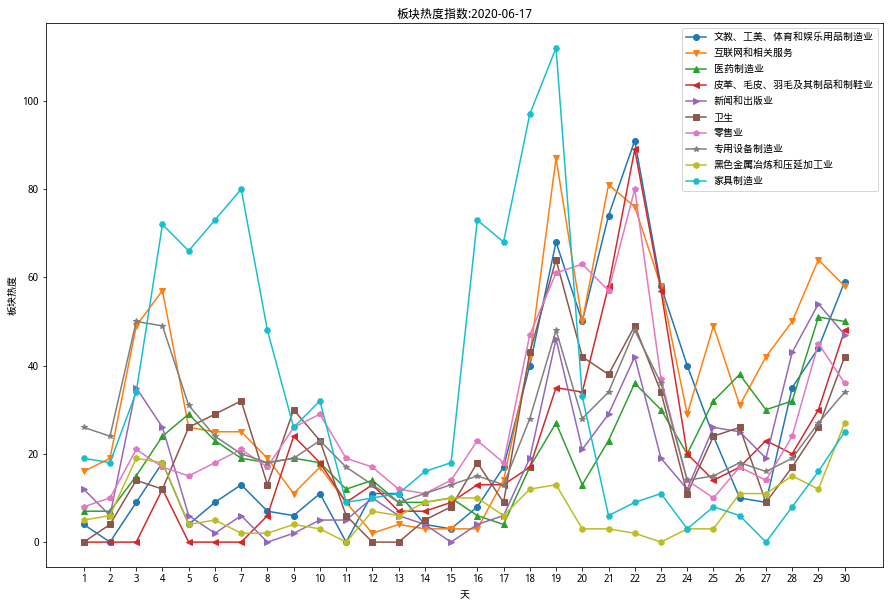

plot_industry_hot cost 0.6238079999999968 second
top_industry cost 4.552429000000018 second
stock_industry cost 0.5148280000000227 second
returns_series cost 0.892374000000018 second


,score,top
sw_l2,,
医疗器械II,133,"[39/62]正川股份:30.28%,硕世生物:28.77%,开立医疗:19.23%,热景生物:17.52%,三鑫医疗:15.81%"
互联网传媒II,73,"[12/53]凯撒文化:19.14%,恺英网络:17.58%,吉比特:12.21%,新媒股份:9.09%,紫光学大:8.13%"
生物制品II,64,"[11/34]未名医药:24.36%,安科生物:20.77%,华熙生物:14.95%,我武生物:7.62%,海特生物:6.89%"
医疗服务II,47,"[6/19]美迪西:16.28%,昭衍新药:9.46%,光正集团:8.52%,通策医疗:6.64%,美年健康:5.59%"
化学制药II,46,"[31/102]美诺华:14.6%,山河药辅:11.34%,普利制药:11.27%,人福医药:10.92%,司太立:10.74%"
一般零售II,44,"[4/44]王府井:12.32%,国芳集团:10.02%,家家悦:6.59%,红旗连锁:5.92%,北京城乡:4.08%"
纺织制造II,35,"[8/28]如意集团:19.91%,江苏阳光:11.63%,金鹰股份:10.8%,华孚时尚:9.13%,三房巷:8.73%"
汽车整车II,30,"[4/19]长安汽车:11.86%,力帆股份:9.09%,长城汽车:6.82%,广汽集团:6.53%,上汽集团:4.71%"
文化传媒II,26,"[13/70]中广天择:17.29%,歌华有线:11.61%,新经典:7.85%,华谊兄弟:7.61%,上海电影:7.54%"


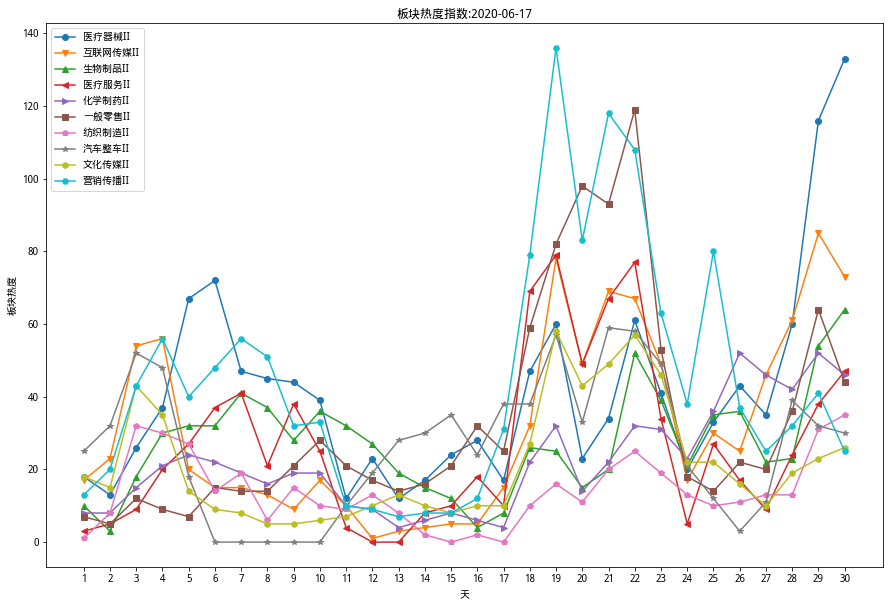

plot_industry_hot cost 0.6891310000000317 second
top_industry cost 5.088986999999975 second
stock_industry cost 0.6690240000000358 second
returns_series cost 0.9037650000000212 second


,score,top
jq_l2,,
医疗保健用品指数,181,"[10/17]正川股份:30.28%,三鑫医疗:15.81%,仙乐健康:15.04%,心脉医疗:14.24%,山东药玻:12.72%"
家庭娱乐软件指数,107,"[5/20]凯撒文化:19.14%,恺英网络:17.58%,吉比特:12.21%,惠程科技:6.46%,电魂网络:5.4%"
医疗保健设备指数,106,"[12/24]开立医疗:19.23%,九安医疗:12.34%,三诺生物:9.29%,凯利泰:9.19%,爱朋医疗:7.67%"
生物科技指数,88,"[29/54]硕世生物:28.77%,普莱柯:25.51%,未名医药:24.36%,安科生物:20.77%,热景生物:17.52%"
休闲用品指数,63,"[2/16]新日股份:13.0%,金陵体育:5.84%,实丰文化:4.04%,英派斯:2.6%,奥飞娱乐:2.35%"
百货商店指数,50,"[2/36]王府井:12.32%,国芳集团:10.02%,供销大集:3.42%,汇嘉时代:2.77%,合肥百货:2.03%"
出版指数,46,"[2/27]新经典:7.85%,博瑞传播:7.11%,粤传媒:3.96%,出版传媒:3.37%,中国出版:2.1%"
西药指数,46,"[34/108]美迪西:16.28%,美诺华:14.6%,山河药辅:11.34%,普利制药:11.27%,人福医药:10.92%"
大卖场与超市指数,45,"[2/11]家家悦:6.59%,红旗连锁:5.92%,北京城乡:4.08%,安德利:2.86%,华联综超:1.9%"


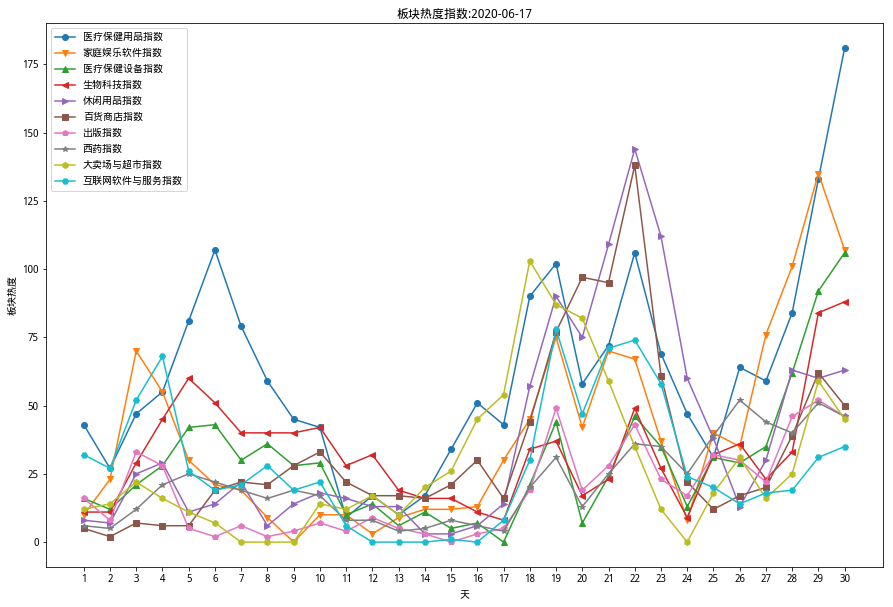

plot_industry_hot cost 0.7135250000000042 second
top_industry cost 5.754456000000005 second


In [154]:
top_industry('2020-06-17','zjw',return_days=5,back_days=30,stock_top_count=5,industry_top_count=10,up_limit=5)
top_industry('2020-06-17','sw_l2',return_days=5,back_days=30,stock_top_count=5,industry_top_count=10,up_limit=5)
top_industry('2020-06-17','jq_l2',return_days=5,back_days=30,stock_top_count=5,industry_top_count=10,up_limit=5)